In [26]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Load dataset
df = pd.read_csv('../data/row/labr_row.csv')
print(f"Initial dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")

Initial dataset shape: (63257, 6)

Column names: ['Unnamed: 0', 'rating', 'review_id', 'user_id', 'book_id', 'review_text']

First few rows:
   Unnamed: 0  rating  review_id   user_id   book_id  \
0           0       4  338670838   7878381  13431841   
1           1       4   39428407   1775679   3554772   
2           2       4   32159373   1304410   3554772   
3           3       1  442326656  11333112   3554772   
4           4       5   46492258    580165   3554772   

                                         review_text  
0   "عزازيل الذي صنعناه ،الكامن في أنفسنا" يذكرني...  
1   من أمتع ما قرأت من روايات بلا شك. وحول الشك ت...  
2   رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ...  
3   إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أس...  
4   الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالع...  


# Handle Missing Values


In [27]:
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nMissing percentage:")
print((df.isnull().sum() / len(df)) * 100)

Missing values per column:
Unnamed: 0     0
rating         0
review_id      0
user_id        0
book_id        0
review_text    0
dtype: int64

Missing percentage:
Unnamed: 0     0.0
rating         0.0
review_id      0.0
user_id        0.0
book_id        0.0
review_text    0.0
dtype: float64


In [28]:
# Store original size
original_size = len(df)
# Drop rows with missing review_text (critical field)
df = df.dropna(subset=['review_text'])
print(f"After dropping missing review_text: {len(df)} rows ({original_size - len(df)} dropped)")
# Drop rows with missing rating (target variable)
df = df.dropna(subset=['rating'])
print(f"After dropping missing rating: {len(df)} rows")
# Drop rows with missing user_id or book_id (essential for graph)
df = df.dropna(subset=['user_id', 'book_id'])
print(f"After dropping missing IDs: {len(df)} rows")
# Handle missing review_id (generate if missing)
if df['review_id'].isnull().sum() > 0:
    df['review_id'] = df['review_id'].fillna(
        df['review_id'].max() + 1 + np.arange(df['review_id'].isnull().sum())
    )
    print(f"Generated {df['review_id'].isnull().sum()} missing review IDs")
print(f"\nFinal missing values:\n{df.isnull().sum()}")

After dropping missing review_text: 63257 rows (0 dropped)
After dropping missing rating: 63257 rows
After dropping missing IDs: 63257 rows

Final missing values:
Unnamed: 0     0
rating         0
review_id      0
user_id        0
book_id        0
review_text    0
dtype: int64


In [29]:
# Check for exact duplicate rows
duplicates = df.duplicated()
print(f"Number of exact duplicate rows: {duplicates.sum()}")
# Remove exact duplicates
df = df.drop_duplicates()
print(f"After removing exact duplicates: {len(df)} rows")
# Check for duplicate review_text (same text, different metadata)
text_duplicates = df.duplicated(subset=['review_text'], keep=False)
print(f"Number of reviews with duplicate text: {text_duplicates.sum()}")
# Inspect some duplicate texts
if text_duplicates.sum() > 0:
    print("\nSample duplicate texts:")
    print(df[text_duplicates][['user_id', 'book_id', 'review_text']].head(10))

Number of exact duplicate rows: 0
After removing exact duplicates: 63257 rows
Number of reviews with duplicate text: 5814

Sample duplicate texts:
      user_id   book_id                                        review_text
74    2286835   3554772   الرق التاسع والعشرون أصابني بشدة . القضية أن ...
79    7457555  13608357   رواية جدّ غريبة ! تحاول الوصول إلى الإنسان بك...
81    4295554   3554772   أول رواية عربية قرأتها "أروع ما قرأت"ـ أحببت ...
127  13555030   3554772                                               تحفه
152   4295554   3554772   أول رواية عربية قرأتها "أروع ما قرأت"ـ أحببت ...
154   7457555  13608357   رواية جدّ غريبة ! تحاول الوصول إلى الإنسان بك...
159   2286835   3554772   الرق التاسع والعشرون أصابني بشدة . القضية أن ...
533  12252292   3554772   اتشرف بدعوة حضراتكم لزيارة صفحة اول مكتبة علي...
723   6017125   3554772                                   من أروع الروايات
754   7770660   3554772                                       اجمل ما قرأت


In [30]:
# Check if same user reviewed same book multiple times
user_book_counts = df.groupby(['user_id', 'book_id']).size()
multiple_reviews = user_book_counts[user_book_counts > 1]
print(f"User-book pairs with multiple reviews: {len(multiple_reviews)}")

if len(multiple_reviews) > 0:
    print(f"Total duplicate reviews: {(user_book_counts - 1).sum()}")
    # Option 2: Keep the first review
    df = df.drop_duplicates(subset=['user_id', 'book_id'], keep='first')
    print(f"After removing user-book duplicates: {len(df)} rows")

User-book pairs with multiple reviews: 3073
Total duplicate reviews: 3105
After removing user-book duplicates: 60152 rows


# Filter Data

## Step 1: Remove very short reviews

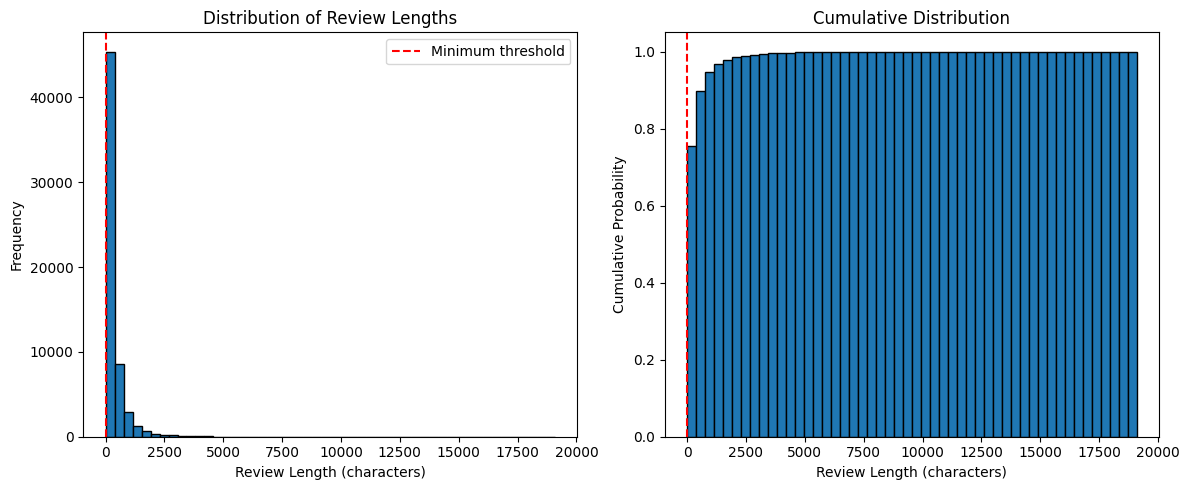

Review length statistics:
count    60152.000000
mean       343.634443
std        600.478206
min          2.000000
25%         74.000000
50%        171.000000
75%        377.000000
max      19088.000000
Name: review_length, dtype: float64

Reviews shorter than 10 characters: 627
After removing short reviews: 59525 rows


In [31]:
# Calculate review lengths
df['review_length'] = df['review_text'].str.len()

# Visualize review length distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['review_length'], bins=50, edgecolor='black')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.axvline(10, color='red', linestyle='--', label='Minimum threshold')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df['review_length'], bins=50, edgecolor='black', cumulative=True, density=True)
plt.xlabel('Review Length (characters)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution')
plt.axvline(10, color='red', linestyle='--')
plt.tight_layout()
plt.show()
plt.close()
# Statistics
print("Review length statistics:")
print(df['review_length'].describe())

# Remove very short reviews (less than 10 characters)
min_length = 10
short_reviews = df['review_length'] < min_length
print(f"\nReviews shorter than {min_length} characters: {short_reviews.sum()}")
df = df[df['review_length'] >= min_length]
print(f"After removing short reviews: {len(df)} rows")

# Step 4: Validate ratings

Rating distribution:
rating
1     2768
2     4990
3    11530
4    17908
5    22329
Name: count, dtype: int64


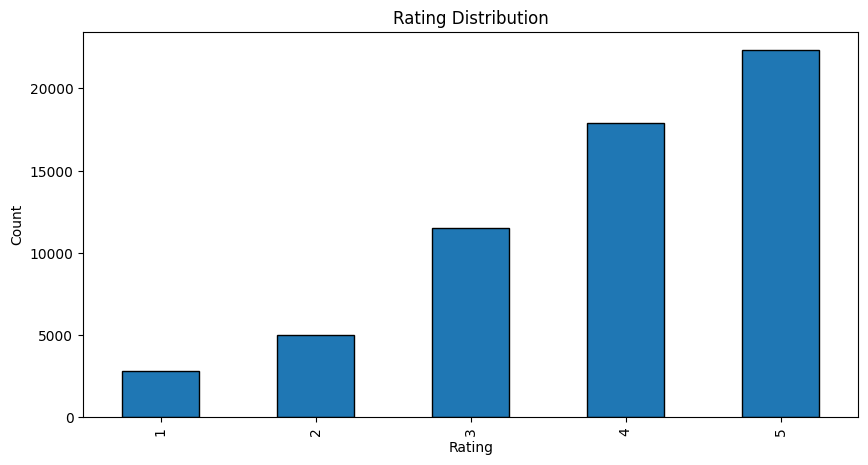


Rating range: 1 to 5


In [32]:
# Check rating distribution
print("Rating distribution:")
print(df['rating'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 5))
df['rating'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()
plt.close()

# Check for invalid ratings
min_rating = df['rating'].min()
max_rating = df['rating'].max()
print(f"\nRating range: {min_rating} to {max_rating}")

# Remove invalid ratings (if any)
valid_ratings = df['rating'].between(1, 5)
if not valid_ratings.all():
    print(f"Invalid ratings found: {(~valid_ratings).sum()}")
    df = df[valid_ratings]
    print(f"After removing invalid ratings: {len(df)} rows")

In [36]:
# Final dataset summary
print("\n" + "="*50)
print("CLEANING SUMMARY")
print("="*50)
print(f"Original dataset size: {original_size}")
print(f"Final dataset size: {len(df)}")
print(f"Rows removed: {original_size - len(df)} ({((original_size - len(df))/original_size)*100:.2f}%)")
print(f"\nNumber of users: {df['user_id'].nunique()}")
print(f"Number of books: {df['book_id'].nunique()}")
print(f"Number of reviews: {len(df)}")
print(f"Sparsity: {1 - (len(df) / (df['user_id'].nunique() * df['book_id'].nunique())):.4f}")

CLEANED_PATH = "../data/processed/labr_cleaned.csv"
# Save cleaned data
df.to_csv(CLEANED_PATH, index=False)
print(f"\nCleaned data saved to: {CLEANED_PATH}")


CLEANING SUMMARY
Original dataset size: 63257
Final dataset size: 59525
Rows removed: 3732 (5.90%)

Number of users: 16303
Number of books: 2126
Number of reviews: 59525
Sparsity: 0.9983

Cleaned data saved to: ../data/processed/labr_cleaned.csv
